In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt
from random import randint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.callbacks import EarlyStopping
from keras import initializers
from matplotlib import pyplot
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import locale

%matplotlib inline

bitcoin_data = pd.read_csv('bitcoin.csv', header = 0, parse_dates=['Date'])
bitcoin_data['Year'] = bitcoin_data['Date'].apply(lambda x: x.year)
bitcoin_data['Month'] = bitcoin_data['Date'].apply(lambda x: x.month)
bitcoin_data = bitcoin_data.loc[bitcoin_data['Date'] > datetime(2016,1,1)]
bitcoin_data.head(3)
bitcoin_data = bitcoin_data.sort_values('Date')
bitcoin_data = bitcoin_data.set_index('Date')

In [16]:
bitcoin_data.head()

,Open,High,Low,Close,Volume,Market Cap,Year,Month
Date,,,,,,,,
2016-01-02,434.62,436.06,431.87,433.44,30096600.0,6.533630e+09,2016,1
2016-01-03,433.58,433.74,424.71,430.01,39633800.0,6.519500e+09,2016,1
2016-01-04,430.06,434.52,429.08,433.09,38477500.0,6.468180e+09,2016,1
2016-01-05,433.07,434.18,429.68,431.96,34522600.0,6.515380e+09,2016,1
2016-01-06,431.86,431.86,426.34,429.11,34042500.0,6.498830e+09,2016,1


In [17]:
df_train = bitcoin_data[0:500]
df_test = bitcoin_data[500:]

In [18]:
scaler = MinMaxScaler()


training_set = df_train.values
training_set = scaler.fit_transform(training_set)
X_train = np.reshape(training_set, (len(training_set),1, df_train.shape[1]))
Y_train = training_set[:,3]


test_set = df_test.values
test_set = scaler.fit_transform(test_set)
X_test = np.reshape(test_set, (len(test_set),1, df_train.shape[1]))
Y_test = test_set[:,3]


In [19]:
Y_train.shape

(500,)

In [20]:
X_train.shape

(500, 1, 8)

In [21]:
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(256))
model.add(Dense(1))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 256)            271360    
_________________________________________________________________
lstm_4 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 796,929
Trainable params: 796,929
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, Y_train, epochs=200, batch_size=16, shuffle=False,
                    validation_data=(X_test, Y_test),
                    callbacks = [EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=20, verbose=1)])

Train on 500 samples, validate on 281 samples
Epoch 1/200
500/500 [==============================] - 1s 3ms/step - loss: 0.0043 - val_loss: 0.0400
Epoch 2/200
500/500 [==============================] - 1s 2ms/step - loss: 0.0111 - val_loss: 0.0126
Epoch 3/200
500/500 [==============================] - 1s 2ms/step - loss: 0.0035 - val_loss: 0.0021
Epoch 4/200
500/500 [==============================] - 1s 2ms/step - loss: 8.2169e-04 - val_loss: 0.0017
Epoch 5/200
500/500 [==============================] - 1s 2ms/step - loss: 0.0060 - val_loss: 0.0154
Epoch 6/200
500/500 [==============================] - 1s 1ms/step - loss: 0.0097 - val_loss: 0.0310
Epoch 7/200
500/500 [==============================] - 1s 1ms/step - loss: 0.0084 - val_loss: 0.0079
Epoch 8/200
500/500 [==============================] - 1s 1ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 9/200
500/500 [==============================] - 1s 1ms/step - loss: 0.0036 - val_loss: 0.0094
Epoch 10/200
500/500 [===================

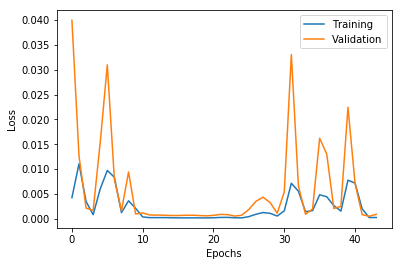

In [23]:
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])

In [24]:
prediction = model.predict(X_test)

In [25]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
Y_test = Y_test.reshape((len(Y_test), 1))

In [26]:
inv_prediction = np.concatenate((prediction, X_test[:, 1:]), axis=1)
inv_prediction = scaler.inverse_transform(inv_prediction)
inv_prediction = inv_prediction[:,0]

Y_test_inverse = np.concatenate((Y_test, X_test[:, 1:]), axis=1)
Y_test_inverse = scaler.inverse_transform(Y_test_inverse)
Y_test_inverse = Y_test_inverse[:,0]

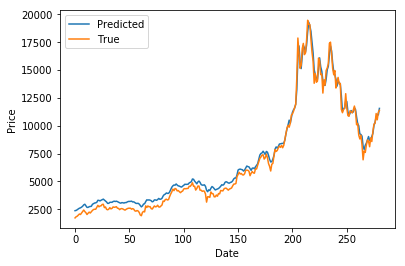

In [27]:
plt.figure()
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(inv_prediction)
plt.plot(Y_test_inverse)
plt.legend(['Predicted', 'True'])